# DS analysis

Goal: investigate what DS level means 

## Setup

In [1]:
%cd work/notebooks

/home/jovyan/work/notebooks


In [2]:
# Import modules and R
import numpy as np, pandas as pd
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [3]:
import sys, os
sys.path.append('../code')
from processing_helpers import *
from analysis_helpers import *
from gradientVersion import *
%R source("../code/Rplots.R");
%R source("../code/brainPlots.R");


Error in library(ggtext) : there is no package called ‘ggtext’


  there is no package called ‘ggsegGlasser’




Error in library(ggsegGlasser) : 
  there is no package called ‘ggsegGlasser’


In [49]:
protein_atlas = pd.read_csv("../data/protein_atlas.csv")

In [58]:
protein_atlas.head()

,symbol,Ensembl gene id,colon,kidney,liver,pancreas,lung,prostate,brain,stomach,...,gall bladder,urinary bladder,thyroid gland,esophagus,heart,skin,ovary,bone marrow,salivary gland,Category
0,METTL25,ENSG00000127720,4.35,4.45,2.51,2.35,4.09,5.03,2.21,4.19,...,4.08,6.73,5.70,4.44,3.56,4.36,6.06,2.22,3.10,Expressed in all low
1,OR13A1,ENSG00000256574,0.02,0.04,0.02,0.00,0.02,0.19,0.00,0.09,...,0.06,0.87,0.01,0.17,0.04,0.01,0.04,0.07,0.11,Not detected
2,PPARGC1A,ENSG00000109819,8.21,25.96,25.39,2.32,5.10,3.27,5.35,4.61,...,3.93,2.81,23.18,4.50,24.55,1.34,1.29,0.01,26.07,Mixed high
3,PSMC2,ENSG00000161057,45.17,51.94,54.34,17.00,45.25,49.72,46.34,49.62,...,47.71,58.42,56.40,59.33,60.10,53.37,37.34,69.13,34.64,Expressed in all high
4,LINC02877,ENSG00000237787,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.08,Not detected


In [51]:
stability = pd.read_csv("../outputs/stability_hcp_ranked.csv", index_col=0).set_index('gene_symbol')

In [102]:
brain_ds = protein_atlas.set_index('symbol')[['brain']].join(stability)
brain_ds

,brain,ds,pct
A1BG,0.83,0.423927,0.920419
A1CF,0.05,NaN,NaN
A2M,97.47,0.074283,0.332999
A2ML1,2.46,-0.027507,0.012856
A4GALT,1.79,0.050894,0.241503
...,...,...,...
NaN,0.19,NaN,NaN
NaN,0.47,NaN,NaN
NaN,0.00,NaN,NaN
NaN,0.03,NaN,NaN


In [70]:
dm_hcp_3d_ds5 = gradientVersion().fit('hcp_3donors_ds5')

New gradients version: method=dm, params={'alpha': 1}, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds5


In [103]:
brain_ds = brain_ds \
    .join(dm_hcp_3d_ds5.weights) \
    .dropna() \
    .set_axis(['brain','ds','pct','G1','G2','G3','G4','G5'], axis=1)
    # .loc[lambda x: np.isin(x.index, dm_hcp_3d_ds5.weights.index)] \
brain_ds

,brain,ds,pct,G1,G2,G3,G4,G5
A1BG,0.83,0.423927,0.920419,-0.015451,-0.004935,0.000698,0.016858,0.006287
AAAS,21.08,0.239969,0.762072,0.011610,0.004924,0.002747,0.021268,0.015137
AAGAB,21.95,0.134598,0.547661,-0.005098,0.019883,-0.014752,0.008614,-0.010404
AAK1,23.54,0.240441,0.762386,0.013312,0.001275,-0.002643,-0.008868,-0.024532
AARD,0.61,0.218268,0.728960,0.013120,-0.002350,-0.007394,-0.011570,-0.000018
...,...,...,...,...,...,...,...,...
ZSWIM9,2.60,0.214529,0.723567,-0.009991,0.000473,0.002506,-0.019019,0.018502
ZWINT,3.99,0.260411,0.789665,-0.012440,-0.008334,0.000574,0.004192,0.005409
ZYX,28.02,0.547722,0.965634,0.017013,0.005947,-0.003734,0.009057,-0.000946
ZZEF1,10.05,0.203827,0.705255,0.013004,-0.012944,0.009702,-0.000583,0.013879


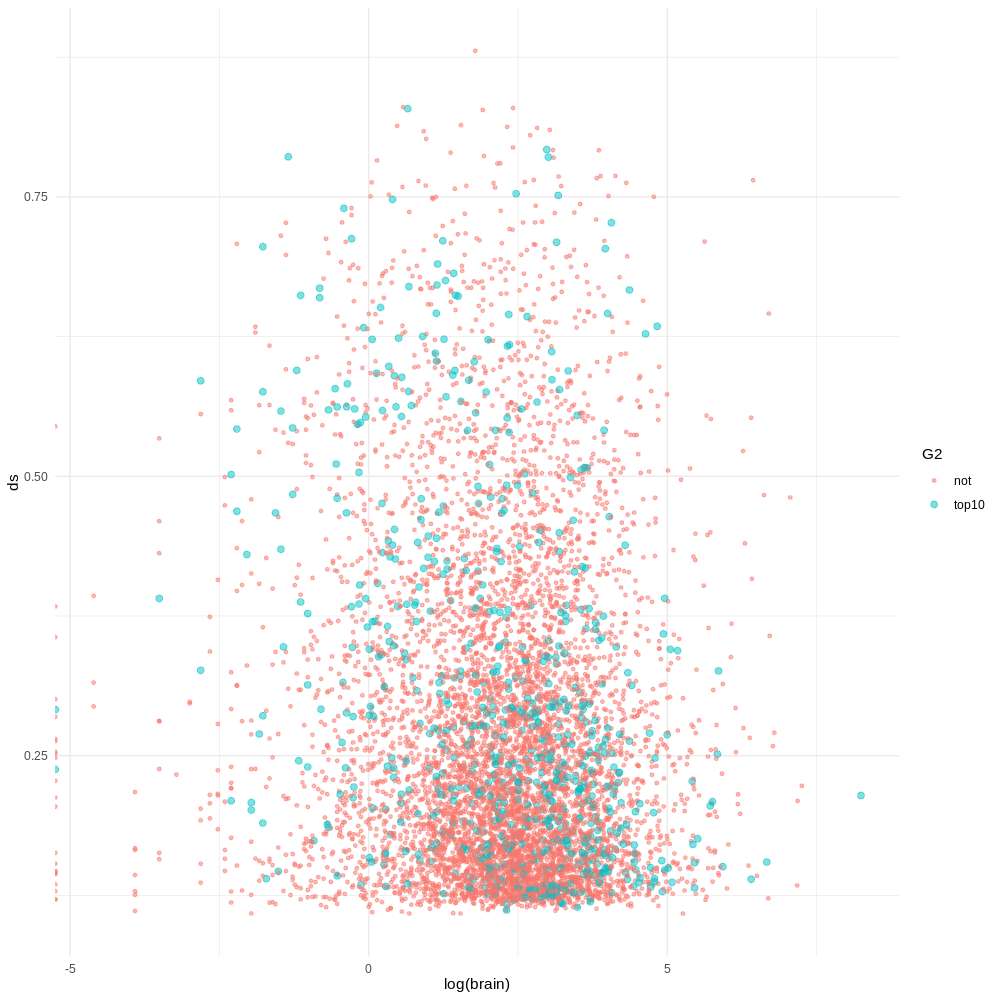

In [98]:
%%R -i brain_ds -w 10 -h 10 --units in -r 100
brain_ds %>%
    mutate(G1 = ifelse(`0` > quantile(`0`, .9),'top10','not'),
           G2 = ifelse(`1` > quantile(`1`, .9),'top10','not'),
           G3 = ifelse(`2` > quantile(`2`, .9),'top10','not')
          ) %>%
ggplot() +
geom_point(aes(log(brain), ds, color=G2, size=G2), alpha=.5) +
scale_size_manual(values=c(1,2)) +
theme_minimal()

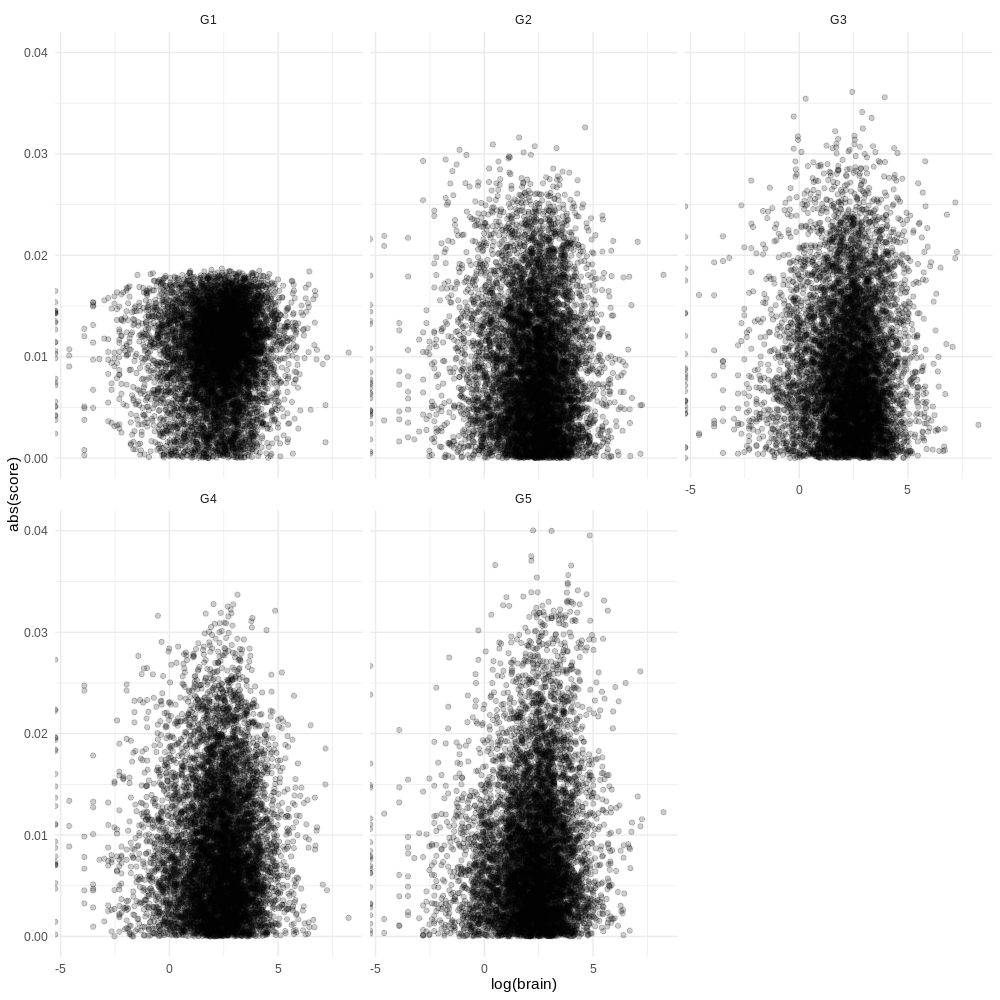

In [113]:
%%R -i brain_ds -w 10 -h 10 --units in -r 100
brain_ds %>%
pivot_longer(G1:G5, names_to='G', values_to='score') %>%
ggplot() +
facet_wrap(~G) +
geom_point(aes(log(brain), abs(score)), alpha=.2) +
theme_minimal()

### Match gene symbols for protein atlas and save

In [37]:
import mygene
mg = mygene.MyGeneInfo()
gene_matches = mg.querymany(protein_atlas['Ensembl gene id'], scopes='ensembl.gene')

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-20050...done.
Finished.
723 input query terms found no hit:
	['ENSG00000267596', 'ENSG00000204533', 'ENSG00000132139', 'ENSG00000215897', 'ENSG00000188279', 'ENS
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [41]:
gene_matches = pd.DataFrame(gene_matches).set_index('query')['symbol']

In [48]:
protein_atlas.join(gene_matches, on='Ensembl gene id').set_index('symbol').to_csv('../data/protein_atlas.csv')

In [36]:
stability

,ds,pct
gene_symbol,,
MET,0.880732,1.000000
SV2C,0.830289,0.999937
RHBDL3,0.829522,0.999875
CTXN3,0.828956,0.999812
SLA,0.827744,0.999749
...,...,...
DEFB123,-0.058273,0.000314
MCAT,-0.058465,0.000251
ARMC6,-0.060564,0.000188


In [18]:
np.median(protein_atlas.drop(['Ensembl gene id', 'Category'],axis=1).values)

5.06

In [22]:
brain_genes = protein_atlas.set_index('Ensembl gene id')['brain'].loc[lambda x: x>5.06*4]

In [ ]:
import mygene
mg = mygene.MyGeneInfo()
gene_matches = mg.querymany(brain_genes.index, scopes='ensembl.gene')

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-4359...done.
Finished.
37 input query terms found no hit:
	['ENSG00000005955', 'ENSG00000017373', 'ENSG00000187145', 'ENSG00000250588', 'ENSG00000077809', 'ENS
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [30]:
matches = pd.DataFrame(gene_matches).loc[:,['query', 'symbol']]

In [33]:
brain_genes.to_frame().join(matches.set_index('query')).

,brain,symbol
Ensembl gene id,,
ENSG00000161057,46.34,PSMC2
ENSG00000189241,108.92,TSPYL1
ENSG00000172020,176.08,GAP43
ENSG00000132604,25.34,TERF2
ENSG00000139218,23.07,SCAF11
...,...,...
ENSG00000171634,22.83,BPTF
ENSG00000158560,61.95,DYNC1I1
ENSG00000138279,60.88,ANXA7


In [34]:
pd.read_csv('../data/jakob_brain_genes.csv')

,gene
0,TSPAN6
1,DPM1
2,SCYL3
3,C1orf112
4,GCLC
...,...
7966,HIST1H4A
7967,HIST1H2AM
7968,HIST1H4B
7969,HIST1H3H
